In [1]:
import math
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
from matplotlib.cm import get_cmap
# import addcopyfighandler

import seaborn as sns

from IPython.core.display import HTML

sys.path.append("../RD-systems-and-test-benches/utils")
import data_processing as dp

import model_fsolve as modf

import scipy.optimize as sco
import scipy.interpolate as sci

import simu as sim

import hx_hydraulic as hxhy
import from_excel as fe

import fluids as fds
from CoolProp.CoolProp import PropsSI

import openpyxl as opxl

import torch
import torch_model as modto

In [2]:
path = r"G:\Drive partagés\BU04-Innovation\PVT-PL-model\Inputs"
file_name = r"\Camilleri_AR0.022.xlsx"

hx, par, condi0 = fe.initialize(path, file_name)

In [3]:
# Test d'un seul débit
tabl_f,res_f = modf.PL_fsolve(par,condi0,print=False, fappx = 10)
tabl, res = modf.PL_fsolve(par,condi0,print=False)

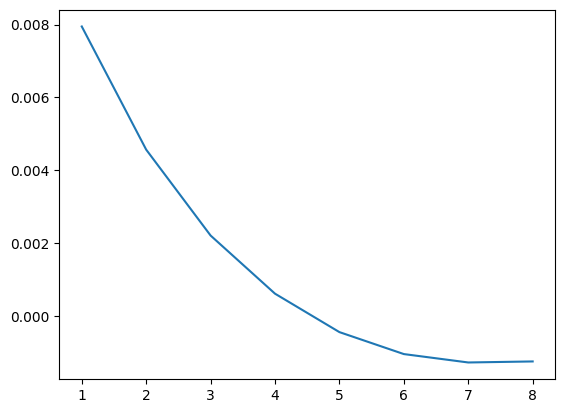

In [4]:
pout = np.array(tabl['Pout'])
poutf = np.array(tabl_f['Pout'])
N = len(pout)
plt.plot([i for i in range(1,N)],[(pout[i]-poutf[i])/pout[i] for i in range(1, N)])

In [5]:
path_outputs = r"G:\Drive partagés\BU04-Innovation\PVT-PL-model\Outputs"
V441_x1_water = fe.read_excel(path_outputs+'\\'+'V4.41_x4'+'_outputs.xlsx')

In [8]:
# Création de la liste de plusieurs débits

# list_Q_L = np.array([64,152,245,319,402,449,597]) # L/h
list_Vdot = np.array([100,500,800,1000])
# list_Vdot = np.array(V4_BTP["Vdot_VFD"])
list_Dv = list_Vdot/3600000 # m3/s

# Test de plusieurs débits 

list_PL,list_tabl,list_mn,list_std = modf.PL_fsolve_range(par,condi0,list_Dv)

2.777777777777778e-05
0.0001388888888888889
0.00022222222222222223
0.0002777777777777778


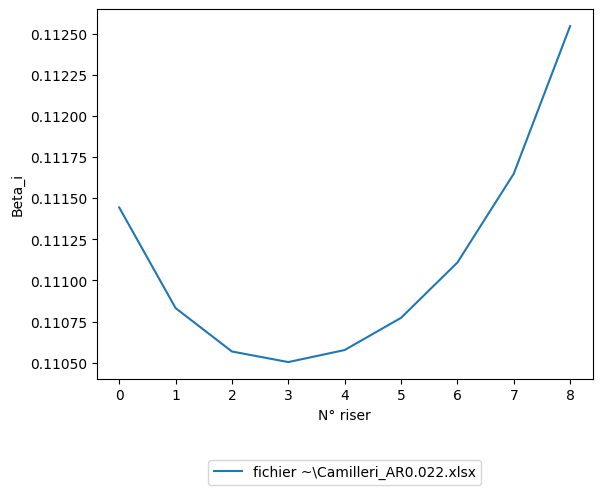

In [9]:
# inverse la liste pour avoir le débit croissant
list_qx = list_tabl[1]['qx'][::-1]
list_qx.reset_index(drop=True,inplace=True)

list_beta = list_qx/list_qx.sum()

plt.plot(list_beta,label=f'fichier ~{file_name}')
plt.xlabel('N° riser')
plt.ylabel('Beta_i')
# plt.plot(test['qx_norm'],label="reference")
 # insérer la légende en dessous
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=2)

In [23]:
list_tabl[1]

,Pin,Pout,qx
0,121684.293654,-5.309027e-21,56.273699
1,121670.399604,1.924338e+02,55.824606
2,121645.571551,3.596207e+02,55.554354
3,121609.901025,5.026327e+02,55.386171
4,121563.424684,6.202235e+02,55.288224
5,121509.515820,7.160111e+02,55.251547
6,121446.375793,7.901563e+02,55.283738
7,121374.097785,8.427342e+02,55.415797
8,121292.557980,8.737184e+02,55.721864


In [24]:
list_PL[1]*10

1212925.5798033744

In [25]:
V441_list_qx = V441_x1_water[1][1]
V441_list_qx = V441_list_qx[::-1]
V441_list_qx.reset_index(drop=True,inplace=True) 

V441_list_qx['Group'] = np.arange(len(V441_list_qx)) // 3

test = V441_list_qx.groupby('Group').agg({'qx': 'sum'})
test['qx_norm'] = test['qx']/test['qx'].mean()

Text(0, 0.5, 'Inlet manifold pressure (kPa)')

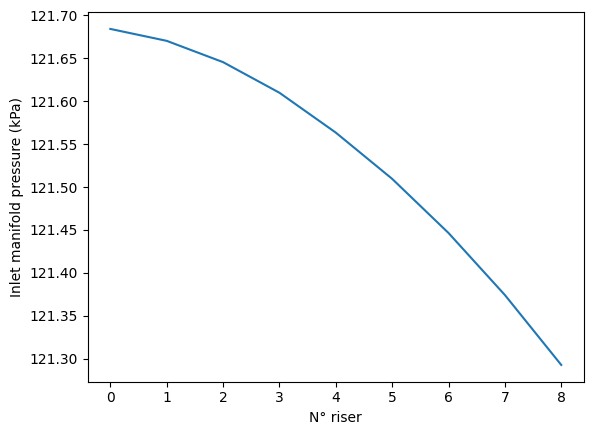

In [26]:
plt.plot(list_tabl[1]['Pin']/1000)
plt.xlabel('N° riser')
plt.ylabel('Inlet manifold pressure (kPa)')

In [27]:
path = r'G:\Drive partagés\BU04-Innovation\PVT-PL-model\Outputs'
create_excel(list_Vdot, list_PL, list_tabl, list_agdf, path+'\\'+name+'_outputs.xlsx')

NameError: name 'create_excel' is not defined

In [ ]:
list_agdf = []

for t in list_tabl:
    t['qx_norm'] = t['qx']/t['qx'].mean()
    t['Group'] = np.arange(len(t)) // par["N_riser_per_panel"]
    # Perform aggregation on the grouped DataFrame
    agdf = t.groupby('Group').agg({'qx': 'sum'})
    agdf['qx_norm'] = agdf['qx']/agdf['qx'].mean()
    list_agdf.append(agdf)

In [ ]:
v441.compute_metrics()

In [ ]:
popt = np.array([-6.43649945e-30,  4.38970645e-26, -1.30021029e-22,  2.19595540e-19,
       -2.33668383e-16,  1.63748979e-13, -7.71542699e-11,  2.48556331e-08,
       -5.69498091e-06,  1.00817834e-03, -1.42045740e-01,  1.19641447e+01])

In [ ]:
q_init = polynomial(np.arange(0,1200,1),*popt)

In [ ]:
plt.plot(nar,q_init)

In [ ]:
q_init2 = polynomial(nar2/(len(nar2)/len(nar)),*popt)


In [ ]:
q_init = (q_init/q_init.sum())*800

In [ ]:
nar = np.arange(0,1200,1)

In [ ]:
plt.plot(nar,q_init)

In [ ]:
q_init.sum()

In [ ]:
polynomial = lambda x, a, b, c, d, e, f, g, h, i, j, k, l: np.polyval([a, b, c, d, e, f, g, h, i, j, k, l], x)

In [ ]:
popt,pcov = sco.curve_fit(polynomial,list_qx_norm.index,list_qx_norm)

In [ ]:
# plt.scatter(tabl.index,tabl['qx_norm'])
plt.scatter(list_qx_norm.index,list_qx_norm,marker="+")
plt.plot(list_qx_norm.index,polynomial(list_qx_norm.index,*popt),color="red")

In [ ]:
new_index = np.arange(0,300*10,1)
new_list_qx_norm = polynomial(new_index/10,*popt)

In [ ]:
new_list_qx_norm = (new_list_qx_norm/new_list_qx_norm.sum())*300*10

In [ ]:
plt.plot(new_index,new_list_qx_norm)

In [ ]:
testdf = pd.DataFrame({'qx_norm':new_list_qx_norm})

In [ ]:
agdf = pd.DataFrame()

testdf['Group'] = np.arange(len(testdf)) // 300
# Perform aggregation on the grouped DataFrame

agdf = testdf.groupby('Group').agg({'qx_norm': 'sum'})

In [ ]:
agdf['norm'] = agdf['qx_norm']/agdf['qx_norm'].sum()

In [ ]:
agdf['real'] = agdf['norm']*1000

In [ ]:
# Test d'un seul débit

coeff_list = np.linspace(1.,10.,1)
res_list = []

for c in coeff_list:
    v441.change_coeff(c,c,c,c)
    par = v441.make_dict()
    tabl,res = modf.PL_fsolve(par,condi0,print=False)
    res_list.append(res)

In [ ]:
V4_TUV = pd.read_excel(r"G:\Drive partagés\BU04-Innovation\BTP\PL-database\V4_TUV.xlsx")

In [ ]:
rho = PropsSI('D', 'P', 1.5*1E5, 'T', 20+273.15, f'INCOMP::MPG[0.]')

In [ ]:
a_x = (2/rho)*12.96*1E15*(math.pi*(0.018/2)**2)**2 * popt[0]
b_x = (2/rho)*3.6*1E9*(math.pi*(0.018/2)**2) * popt[1]

In [ ]:
V4_TUV['u'] = (V4_TUV['Vdot']/(1000*3600))/(math.pi*(0.018/2)**2)

In [ ]:
popt, pcov = sco.curve_fit(lambda x,a,b : a*x**2 + b*x, V4_TUV["Vdot"], V4_TUV["PL"])

In [ ]:
popt_x,pcov_x = sco.curve_fit(lambda x,a,b : a*x**2 + b*x, V4_TUV["u"], V4_TUV["PL"]*1000)

In [ ]:
a_x = popt_x[0]
b_x = popt_x[1]

In [ ]:
plt.scatter(V4_TUV["Vdot"],V4_TUV["PL"])
plt.plot(V4_TUV["Vdot"],popt[0]*V4_TUV["Vdot"]**2 + popt[1]*V4_TUV["Vdot"])
plt.plot(V4_TUV["Vdot"],(a_x*V4_TUV["u"]**2 + b_x*V4_TUV["u"])/1000)

In [ ]:
V4_BTP = pd.read_csv("PL_2_V4.41.csv")
V4_BTP.drop(columns=["Unnamed: 0"],inplace=True)
V4_BTP = V4_BTP.loc[V4_BTP["Vdot_VFD"].isin([50,100,200,300,400,500,600])]

In [ ]:
V4_BTP["PL_model"] = np.array(list_PL)/1000

In [ ]:
uncertainity = 0.1*np.array(list_PL)/1000
V4_BTP["uncertainity"] = uncertainity

In [ ]:
# pl.fill_between(x, y-error, y+error,
# alpha=1, edgecolor='#3F7F4C', facecolor='#7EFF99',
# linewidth=0)

In [ ]:
plt.plot(V4_TUV["Vdot"],V4_TUV["PL"],label="TUV")
#plt.plot(V4_BTP["Vdot_VFD"],V4_BTP["PL2"],label="BTP",color="orange")

plt.errorbar(V4_TUV["Vdot"],V4_TUV["PL_model"],V4_TUV["uncertainity"],fmt='-o',label="model for conditions at TUV",color="blue")
# plt.errorbar(list_Vdot,V4_BTP["PL_model"],uncertainity,fmt='-o',label="model for conditions n°2",color="darkorange")
# plt.fill_between(list_Vdot,V4_BTP["PL_model"] - V4_BTP["uncertainity"],V4_BTP["PL_model"] + V4_BTP["uncertainity"],alpha=1,facecolor="moccasin")
plt.fill_between(V4_TUV["Vdot"],V4_TUV["PL_model"] - V4_TUV["uncertainity"],V4_TUV["PL_model"] + V4_TUV["uncertainity"],alpha=1,facecolor="lightcyan")
plt.legend()

In [ ]:
sns.lineplot(data=V4_TUV, x='Vdot', y='PL', err_style='bars', yerr='uncertainity')

In [ ]:
sns.lineplot(data=V4_TUV, x='Vdot', y='PL',ci=0.9)

In [ ]:
debit_moyen = 210/165 # L/h
flow = debit_moyen/3600000 # m3/s
flow_lent = flow/10
rho = 997
nu = 0.896*1e-6
eta = rho*nu
d_riser = 0.005
Aire = math.pi*(d_riser/2)**2

Re = fds.core.Reynolds(flow/Aire,d_riser,rho,mu=eta)
print(Re)

In [ ]:
mdot = flow*1000 # kg/s (hypothse rho = 1000)
mdot_lent = flow_lent*1000
Cp = 4180
DT_moy = 2
Pth = mdot*Cp*DT_moy
DT_lent = Pth/(mdot_lent*Cp)
print(DT_lent)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%reload_ext autoreload

In [ ]:
dict = {'V4.41' : (list_PL,list_tabl,list_mn,list_std)}

In [ ]:
dict["MICOE"] = (sim.modf_parametric_flow_rates(par,list_Q))

In [ ]:
list_PL = np.array(list_PL)/1000

In [ ]:
list_PL_save = list_PL.copy()
list_tabl_save = list_tabl.copy()
list_mn_save = list_mn.copy()
list_std_save = list_std.copy()

In [ ]:
spr_x = [60,100,120,140,160,180,200]
spr_y = [0.30,0.60,0.70,0.80,1.10,1.50,1.90]

In [ ]:
perc_diff = []
for i in range(len(list_PL_save)):
    perc_diff.append('+'+str(int((((list_PL[i] - list_PL_save[i])/list_PL_save[i])*100)))+'%')

In [ ]:
#plt.scatter(spr_x,spr_y,label="S375 measured",marker='+',color='grey')
#plt.plot(list_Q_L,m_spr(list_Q_L),'--',color='grey')
#plt.scatter(list_Q_L,np.array(list_PL_save)/1000,marker='+',label="V4.41 with wall = 0.35 mm")
#plt.plot(list_Q_L,np.array(m1(list_Q_L))/1000,'--')
plt.scatter(list_Q_L,np.array(dict["MICOE"][0]),marker='+',label = "MICOE")
#plt.plot(list_Q_L,np.array(m2(list_Q_L))/1000,'--')


#for i, v in enumerate(perc_diff):
#    plt.annotate(v, xy=(list_Q_L[i],(np.array(list_PL)/100)[i]),xytext=(-7,7), textcoords='offset points')

plt.xlabel('Flow rate (L/h)')
plt.ylabel('Pressure loss (kPa)')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [ ]:
m1 = np.poly1d(np.polyfit(list_Q_L, list_PL_save, 2))
m2 = np.poly1d(np.polyfit(list_Q_L, list_PL, 2))
m_spr = np.poly1d(np.polyfit(spr_x, spr_y, 2))

In [ ]:
# ancienne version 15 mm de large et 4,4 mm de hauteur 
# a = 0.00171969
# b = 0.123036

# nouvelle version 3 par 3 (mm)
# a = 0.00337677
# b = 1.41816

a = 9.7*1E-7*1000
b = 0.001472*1000

# a = 0.0427594
# b = 20.81999

SW = [421.66,801.75,1159.49,1641.60,2205.57]

sim.plot_PL_harp(par,list_Q_L,list_PL,a,b,SW,5)

axes = plt.gca()
axes.set_xlim(0,1400)
plt.show()
#sim.plot_PL_harp(par,list_Q_L,list_PL,a,b,5)
# sim.plot_abs_flow_rates_harp(par,list_Q_L,list_tabl,list_mn)
sim.plot_flow_rates_harp(par,list_Q_L,list_PL,list_tabl,list_mn)

In [ ]:
PL_measured = (a*list_Q_L**2 + b*list_Q_L)

plt.scatter(list_Q_L,PL_measured,label='SW Flow Simulation')

for i in range(len(save)):
    plt.plot(np.array(list_Q_L),np.array(save[i][0]),label=str(test_list[i]))

plt.legend()
plt.xlabel('Q (L/h)')
plt.ylabel('PL (Pa)')
plt.grid()
plt.show()

In [ ]:
PL_measured = (a*list_Q_L**2 + b*list_Q_L)
RMSE1 = math.sqrt(mean_squared_error(list_PL,PL_measured))
RMSE2 = math.sqrt(mean_squared_error(SW,PL_measured))
moyenne = np.mean(PL_measured)
print(moyenne)
print(round(RMSE1/moyenne,2),round(RMSE2/moyenne,2))


rel_err1 = np.round((np.array(list_PL)-np.array(PL_measured))/np.array(PL_measured),2)
rel_err2 = np.round((np.array(SW)-np.array(PL_measured))/np.array(PL_measured),2)

print(rel_err1)
print(rel_err2)

In [ ]:
sim.repartition_PL(par,list_PL,list_tabl,list_Q)
sim.plt_repartition_PL(par,list_Q_L,list_PL,list_tabl,120,'ok')

In [ ]:
# Calcul coefficient total

deb = list_Q[8]
Cfi = modf.Kxin(par,deb/2,deb/24,2)
Cfe = modf.Kxout(par,deb/2,deb/24,2)

Rex_i = fds.core.Reynolds(deb/par['Ax'],par['Dx'],par['rho'],mu=par['eta'])
fx_i = fds.friction.friction_factor(Re = Rex_i)
ax_i = fx_i*(par['Lx']/par['Dx'])

print(1+Cfi+Cfe+ax_i)
print(par['Ly']*24)
print((par['Ly']*24)/par['Din'])

In [ ]:
# Test pertes de charge régulières

deb = list_Q[0]
Cfi = modf.Kxin(par,deb/2,deb/24,2)
Cfe = modf.Kxout(par,deb/2,deb/24,2)

Ax = (0.010*0.015)

Rex_i = fds.core.Reynolds(deb/Ax,par['Dx'],par['rho'],mu=par['eta'])
fx_i = fds.friction.friction_factor(Re = Rex_i)
ax_i = fx_i*(par['Lx']/par['Dx'])

print(1+Cfi+Cfe+ax_i)
print(par['Ly']*24)
print((par['Ly']*24)/par['Din'])

In [ ]:
# Inputs for singular pressure losses

d_epdm = 0.015
d_red = 0.0078 # 0.011 en pratique, diminué à 0.0078 pour que les PL + 2m EPDM fit aux mesures exp Technoptic avec SSA
d_man = 0.0081 # 13 mm de base, quand le manifold ne fait plus que 5 mm de hauteur c'est 8,1 mm de diamètre hydraulique

L_epdm = 2.

angle_bm_epdm = 90.
angle_bm_man = 90.

In [ ]:
PL_tot,PL_tot_lin,exp_PL_tot,cont_diff,bends,harp,reg = sim.sing_PL(par,d_epdm,d_red,d_man,L_epdm,angle_bm_epdm,angle_bm_man,list_Q_L,list_PL)

In [ ]:
# Singular losses in fittings - Stacked bars chart

labels = ['10', '50', '100', '150', '200']

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, cont_diff, width, label='Sharp contractions and diffusers')
ax.bar(labels, bends, width, bottom=cont_diff,label='Bends (x4)')
ax.bar(labels, harp, width, bottom=cont_diff+bends,label='Harp exchanger')
ax.bar(labels, reg, width, bottom=cont_diff+bends+harp,label='Linear PL')

ax.set_ylabel('PL (Pa)')
ax.set_title('SPRING')
ax.legend()

plt.show()

In [ ]:
save = [PL_tot,PL_tot_lin,exp_PL_tot,cont_diff,bends,harp,reg]

In [ ]:
save2 = [PL_tot,PL_tot_lin,exp_PL_tot,cont_diff,bends,harp,reg]

In [ ]:
ratio = (PL_tot_lin-save[1])/save[1]

plt.plot(list_Q_L,ratio)
plt.xlabel('Q (L/h)')
plt.ylabel('PL increase')
plt.title('SPRING h5 mm PL increase in % of SPRING h10 mm PL')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.grid()
plt.show()

In [ ]:
plt.plot(list_Q_L,PL_tot,label='Total pressure losses')

plt.legend()
plt.xlabel('Q (L/h)')
plt.ylabel('Re')

plt.grid()

In [ ]:
print(list_Q_L)
print(list_PL)
print(list_mn)
print([list_Q_L[i]/par["N"] for i in range(len(list_Q_L))])

# df_res = pd.DataFrame([np.array(list_Q_L),np.array(list_PL)],columns = ['Q_L','PL (Pa)'])
# display(HTML(df_res.to_html()))  


In [ ]:
# Répartition des débits par canal (en valeur absolue)

list_Q_L_round = [round(num, 0) for num in list_Q_L]
risers = np.linspace(0,164,165)

for i in range(len(list_tabl)):
    plt.plot(risers,np.array(list_tabl[i]['qx']),label=str(list_Q_L_round[i])+' L/h')
    plt.legend()

plt.xlabel('N° riser')
plt.ylabel('qx (L/h)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

In [ ]:
# Répartition des débits par canal (en valeur relative au débit moyen attendu)

for i in range(len(list_tabl)):
    plt.plot(risers,np.array(list_tabl[i]['qx'])/list_mn[i],label=str(list_Q_L_round[i])+' L/h')
    plt.legend()

plt.xlabel('N° riser')
plt.ylabel('qx (L/h)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

In [ ]:
# Test paramétrique sur  la heuteur de canal

print(list_PL)
print(list_tabl[0])

print(par['N'])
# param_name = 'l_riser'
# test_list = par['EP']*np.array([2,6,12,18,24])
param_name = 'h_riser'
test_list = [0.001,0.002,0.003,0.004]
save = []

for i in range(len(test_list)):
    sim.preproc(par,param_name,test_list[i])
    list_PL,list_tabl,list_mn,list_std = sim.modf_parametric_flow_rates(par,list_Q)
    save.append([list_PL,list_tabl,list_mn,list_std])

# Plot pressure losses

h_riser_tests = ['3 mm','4.4 mm','6 mm']
colors = ['orange','green','red']

for i in range(len(h_riser_tests)):
    plt.plot(np.array(list_Q_L),np.array(save_h_riser[i+1][0]),label=h_riser_tests[i],color=colors[i])

plt.xlabel('Q (L/h)')
plt.ylabel('PL (Pa)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.legend()

plt.show()


In [ ]:
# Plot pressure losses

plt.plot(np.array(list_Q_L),np.array(list_PL))

plt.xlabel('Q (L/h)')
plt.ylabel('PL (Pa)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()
print([list_Q_L[i]/par['N'] for i in range(len(list_Q_L))])

In [ ]:
# Plot mean and standard deviation of flow rate

plt.plot(np.array(list_Q_L),np.array(list_mn))
plt.plot(np.array(list_Q_L),np.array(list_std))

plt.xlabel('Q (L/h)')
plt.ylabel('Flow rate (L/h)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

In [ ]:
# Plot standard deviation of flow rate / mean flow rate

plt.plot(np.array(list_Q_L),np.array(list_std)/np.array(list_mn))

plt.xlabel('Q (L/h)')
plt.ylabel('Ratio of flow rate standard deviation out of mean flow rate')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

In [ ]:
print(np.array(list_std))
print(np.array(list_mn))
print(np.array(list_std)/np.array(list_mn))

In [ ]:
risers = np.linspace(0,165,166)